# Introduction: Problem Description

- Data represents weekly 2018 retail scan data for National retail volume (units) and price.
- Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados.
- The Average Price (of avocados) in the table reflects per unit (per avocado) cost
- The Product Lookup codes (PLU’s) in the table are only for Hass avocados

Some relevant columns in the dataset are: 

    - Date - The date of the observation
    - AveragePrice - the average price of a single avocado
    - type - conventional or organic
    - year - the year
    - Region - the city or region of the observation
    - Total Volume - Total number of avocados sold
    - 4046 - Total number of avocados with PLU 4046 sold
    - 4225 - Total number of avocados with PLU 4225 sold
    - 4770 - Total number of avocados with PLU 4770 sold
    
Main Research Questions are: <br>
- 1) Was the Avocadopocalypse of 2017 real? (taken from Kaggle)
- 2) What is the potential price which customers would have to pay for Conventional-Avocados in early 2018 respectively 2019?
 <br>    
Original source of the Kaggle Competiion: https://www.kaggle.com/neuromusic/avocado-prices

## 1. Library and data-import

In [1]:
## Basic processing
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import calendar
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## Plotting
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
from plotly import tools
py.init_notebook_mode(connected=True)

## Statsmodel + ARIMA
import scipy.stats as scs
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Model Comparison
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [112]:
df = pd.read_csv('avocado.csv', index_col = 'Date', parse_dates = True)
df = df.drop('Unnamed: 0', axis = 1)
df = df.sort_values(by='Date')

## 2. Exploratory Data Analysis of the Dataset

In [113]:
df_total = df[df['region'] == 'TotalUS']

In [114]:
df_total.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-01-04,0.95,31324277.73,12357161.34,13624083.05,844093.32,4498940.02,3585321.58,894945.63,18672.81,conventional,2015,TotalUS
2015-01-04,1.46,612910.15,233286.13,216611.20,4370.99,158641.83,115068.71,43573.12,0.00,organic,2015,TotalUS
2015-01-11,1.42,669528.88,270966.74,260971.60,3830.42,133760.12,106844.49,26915.63,0.00,organic,2015,TotalUS
2015-01-11,1.01,29063542.75,11544810.53,12134773.38,866574.66,4517384.18,3783261.16,718333.87,15789.15,conventional,2015,TotalUS
2015-01-18,1.42,713120.00,254319.58,311811.01,4020.85,142968.56,101850.23,41118.33,0.00,organic,2015,TotalUS


In [115]:
## Subset by Conventional/Organic
df_total_con = df_total[df_total['type'] == 'conventional']
df_total_org = df_total[df_total['type'] == 'organic']

## Subset dfs
df_total_con = df_total_con[['AveragePrice']]
df_total_org = df_total_org[['AveragePrice']]

## merge both df_total's together
df_total_merge = pd.concat([df_total_con, df_total_org], axis=1)
df_total_merge.columns = ['Average_Price_Conventional', 'Average_Price_Organic']

### 2.1 Time-Series Plot

Obviously, as one can see from the plot below, the organic avocado is more expensive than conventional one.

In [6]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    ''' Generate scatter plot for entire dataframe. '''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
        
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index]
        )
        
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [7]:
df_scatter(df_total_merge, 'Average Avocado Price from 2015 to 2018', y_axis_label='Price in USD')

### 2.2 Pie-chart: Different types of avocados

Organic vs Conventional : The main difference between organic and conventional food products are the chemicals involved during production and processing. The interest in organic food products has been rising steadily over the recent years with new health super fruits emerging.

Visualization idea influenced by: https://www.kaggle.com/rishpande/avocado-prices-data-visualization-beginner
<p>
Code influenced by: 

In [8]:
typeof=df_total.groupby('type')['Total Volume'].agg('sum')
values=[typeof['conventional'],typeof['organic']]
labels=['conventional','organic']

colors = ['#E1396C', '#96D38C']

trace = go.Pie(labels=labels, values=values,   
               hoverinfo='percent', textinfo='percent', 
               textfont=dict(size=20),
               marker=dict(colors=colors, 
               line=dict(color='#000000', width=2)))

py.iplot([trace])

### 2.3 Price-distribution

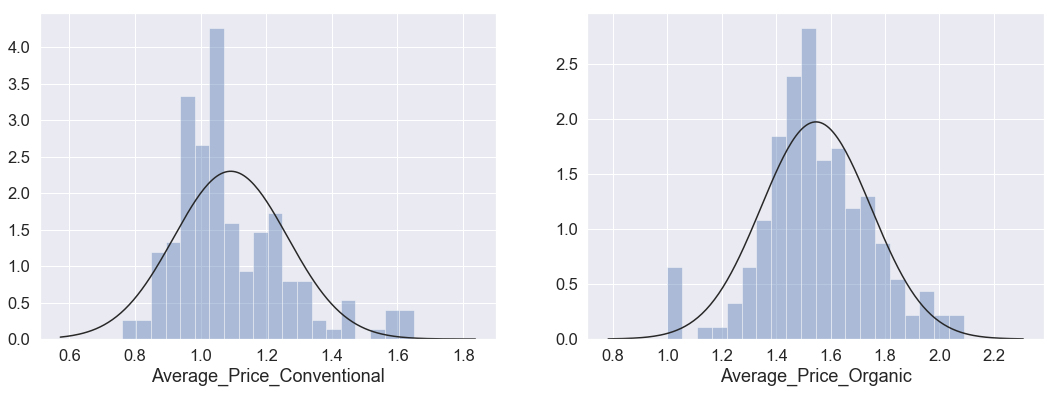

In [9]:
sns.set(font_scale=1.5) 
from scipy.stats import norm
fig, ax = plt.subplots(figsize=(18, 6), ncols = 2, nrows = 1)
sns.distplot(df_total_merge['Average_Price_Conventional'], kde = False, ax=ax[0], fit = norm, bins = 20)
sns.distplot(df_total_merge['Average_Price_Organic'], kde = False, ax=ax[1], fit = norm, bins = 20)

Overall speaking, the average or median price of organic avocado (which is around 1.6) is higher than the one of conventional avocado (around 1.00). However, as one can still see there are some outliers in both conventional and organic avocados.

In [10]:
y0 = df_total_merge['Average_Price_Conventional']
y1 = df_total_merge['Average_Price_Organic']

trace0 = go.Box(
    y=y0,
    name = 'Average Price - Conventional',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'Average Price - Organic',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
) 

data = [trace0,trace1]
layout = go.Layout(
    title = "Price Distribution: Conventional vs. Organic"   

)
  
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)   

### 2.4 Price developement in each month

In [11]:
## influenced by: https://www.kaggle.com/shahules/avocado-apocalypse
## Datetime-handling (Year, Month, date): https://www.kaggle.com/yemregundogmus/avocado-prices-analysis-and-prediction
## Plot-code influenced by Plotly: https://plot.ly/python/time-series/

dates = df_total_merge.index 
date = dates.strftime('%Y-%m-%d') 
dstr = date.tolist() 
df_total_merge['Date_string'] = dstr

df_total_merge['year']=df_total_merge['Date_string'].apply(lambda x : x.split("-")[0])
df_total_merge['month']=df_total_merge['Date_string'].apply(lambda x : calendar.month_name[datetime.strptime(x,"%Y-%m-%d").month])
df_total_merge['day']=df_total_merge['Date_string'].apply(lambda x : calendar.day_name[datetime.strptime(x,"%Y-%m-%d").weekday()])

In [12]:
date_15 = df_total_merge[df_total_merge['year'] == '2015']
date_16 = df_total_merge[df_total_merge['year'] == '2016']
date_17 = df_total_merge[df_total_merge['year'] == '2017']
date_18 = df_total_merge[df_total_merge['year'] == '2018']

#### 2.4.1 Price for Conventional Avocados (grouped by months)

In [13]:
price_15 = date_15.groupby('month')['Average_Price_Conventional'].agg('mean')
price_15 = price_15.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_15 = pd.DataFrame(price_15)

price_16 = date_16.groupby('month')['Average_Price_Conventional'].agg('mean')
price_16 = price_16.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_16 = pd.DataFrame(price_16)

price_17 = date_17.groupby('month')['Average_Price_Conventional'].agg('mean')
price_17 = price_17.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_17 = pd.DataFrame(price_17)

price_18 = date_18.groupby('month')['Average_Price_Conventional'].agg('mean')
price_18 = price_18.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_18 = pd.DataFrame(price_18)

In [14]:
def my_plot_func (trace1, trace2, trace3, trace4, title, title2, name1, name2, name3, name4):
    
    trace_1 = go.Scatter(
                x=trace1.index,
                y=trace1,
                name = name1,
                line = dict(color = '#17BECF'),
                opacity = 0.8)
    
    trace_2 = go.Scatter(
                x=trace2.index,
                y=trace2,
                name = name2,
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    
    trace_3 = go.Scatter(
                x=trace3.index,
                y=trace3,
                name = name3,
                #line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    
    trace_4 = go.Scatter(
                x=trace4.index,
                y=trace4,
                name = name4,
                #line = dict(color = '#7F7F7F'),
                opacity = 0.8)
    
    data = [trace_1, trace_2, trace_3, trace_4]
    
    layout = dict(
    title = title,
    yaxis=dict(title=title2),
    xaxis = dict(
        range = ['2015-01-01','2018-12-31'])
    
    )
    
    fig = dict(data=data, layout=layout)
    py.iplot(fig)

In [15]:
my_plot_func(trace1 = price_15['Average_Price_Conventional'], trace2 = price_16['Average_Price_Conventional'], 
             trace3 = price_17['Average_Price_Conventional'], trace4 = price_18['Average_Price_Conventional'], 
             title = 'Price devolopement (grouped by months) for Conventional Avocados', 
             title2='Average Price in USD', name1 = '2015', name2 = '2016', name3 = '2017', name4 = '2018')

#### 2.4.2 Price for Organic Avocados (grouped by months)

In [16]:
price_15 = date_15.groupby('month')['Average_Price_Organic'].agg('mean')
price_15 = price_15.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_15 = pd.DataFrame(price_15)

price_16 = date_16.groupby('month')['Average_Price_Organic'].agg('mean')
price_16 = price_16.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_16 = pd.DataFrame(price_16)

price_17 = date_17.groupby('month')['Average_Price_Organic'].agg('mean')
price_17 = price_17.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_17 = pd.DataFrame(price_17)

price_18 = date_18.groupby('month')['Average_Price_Organic'].agg('mean')
price_18 = price_18.loc[['January','February','March',"April",'May','June',"July","August",'September','October','November',"December"]]
price_18 = pd.DataFrame(price_18)

In [17]:
my_plot_func(trace1 = price_15['Average_Price_Organic'], trace2 = price_16['Average_Price_Organic'], 
             trace3 = price_17['Average_Price_Organic'], trace4 = price_18['Average_Price_Organic'], 
             title = 'Price devolopement (grouped by months) for Organic Avocados', 
             title2='Average Price in USD', name1 = '2015', name2 = '2016', name3 = '2017', name4 = '2018')

In [18]:
df_melt = pd.melt(frame = df_total_merge, 
                  id_vars=['Date_string', 'year', 'month', 'day'], 
                  value_vars=['Average_Price_Conventional', 'Average_Price_Organic'])

In [19]:
df_melt['Type'] = df_melt['variable'].replace({'Average_Price_Conventional': 'Conventional', 'Average_Price_Organic': 'Organic'})
df_melt = df_melt.rename(columns={'value': 'Average Price'})

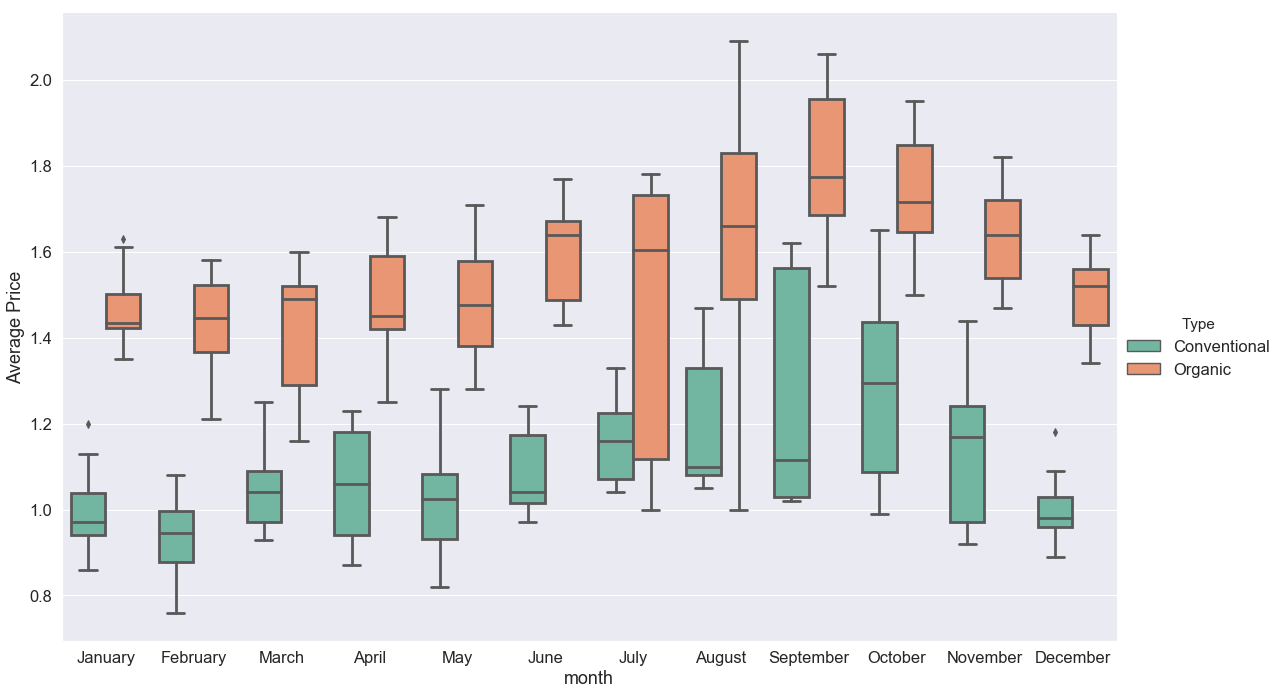

In [20]:
sns.catplot(x="month", y="Average Price", hue="Type", kind="box", data=df_melt, palette="Set2", height=10, linewidth=2.8, aspect=1.6);

### 2.5 Mean volume sold

In [21]:
## Code influenced by: https://www.kaggle.com/shahules/avocado-apocalypse

conv=df_total[df_total['type']=='conventional'].groupby('year')['Total Volume'].agg('mean')
org=df_total[df_total['type']=='organic'].groupby('year')['Total Volume'].agg('mean')

trace1=go.Scatter(x=conv.index,y=conv,name="conventional")
trace2=go.Scatter(x=org.index,y=org,name='organic')
fig=tools.make_subplots(rows=1,cols=2)
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,2)

fig['layout'].update(height=500, title="Average Volume Sold from 2015 to 2018", barmode="stack", showlegend=True,yaxis=dict(title="Mean Volume sold"))

py.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### 2.6 Price vs. Total volume sold comparison over time

In [116]:
## Code was influenced by: 
# [1] https://plot.ly/python/multiple-axes/
# [2] https://plot.ly/pandas/multiple-axes/

df_con_vol = df_total[df_total['type'] == 'conventional']
df_con_vol = df_con_vol[['AveragePrice', 'Total Volume']]

trace1 = go.Scatter(
    x=df_con_vol.index,
    y=df_con_vol['AveragePrice'],
    name='Price'
)
trace2 = go.Scatter(
    x=df_con_vol.index,
    y=df_con_vol['Total Volume'],
    name='Volume',
    yaxis='y2'
)
data = [trace1, trace2]
layout = go.Layout(
    title='Average Price vs. Total Volume sold from 2015 to 2018',
    yaxis=dict(
        title='Average Price in USD'
    ),
    yaxis2=dict(
        title='Total Volume sold',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### 2.7 Analysis of average volume sold by region

In [22]:
## Subset df
df1 = df[df['region'] != 'TotalUS']
df1 = df1[['region', 'Total Volume']]

## Groupby mean
df2 = df1.groupby('region')['Total Volume'].agg('mean')

## Convert to dataframe
df3 = pd.DataFrame(df2)
df3 = df3.reset_index()

## Sort by Total Volume
df_sort = df3.sort_values(by=['Total Volume'], ascending=False)

In [23]:
trace = go.Bar(
    x=df_sort['region'],
    y=df_sort['Total Volume'],
    marker=dict(
        color='#009999'
    )    
)

data = [trace]
layout = go.Layout(
    width=1020,
    height=700,
    title='Total Volume of sold Avocados grouped by Regions (2015-2018)',
    xaxis=go.layout.XAxis(
        title='',
        automargin = True
    ),
    
        yaxis=dict(
        title='Total Volume sold (in Millions)',

    ),  
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 3. Testing for Stationarity

### 3.1 Decomposition

These are the three components of a time series:

 - Trend - consistent upwards or downwards slope of a time series
 - Seasonality - clear periodic pattern of a time series
 - Noise - outliers or missing values

In [24]:
def plot_line(x,y,color,name) :
    tracer = go.Scatter(x = x,y = y,mode = "lines",
                        marker = dict(color = color,
                                      line = dict(width =1)),
                       name = name)
    return tracer

def plot_layout(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                            zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b = 100)
                       )
                  )
    return layout

In [25]:
def plot_decomposition (df, ts, trend, seasonal, residual, title):
    
    #plotting
    t1 = plot_line(df.index, df[ts], "blue","Observed")
    t2 = plot_line(df.index, trend[ts], "green","Trend")
    t3 = plot_line(seasonal.index, seasonal[ts], "red","Seasonality")
    t4 = plot_line(residual.index, residual[ts], "black","Residuals")
    
    #subplots
    fig = tls.make_subplots(rows = 4,cols = 1,subplot_titles = ("Observed", "Trend", "Seasonality", "Residuals"))
    fig.append_trace(t1,1,1)
    fig.append_trace(t2,2,1)
    fig.append_trace(t3,3,1)
    fig.append_trace(t4,4,1)
    
    #layout
    fig["layout"].update(height = 750,
                     plot_bgcolor  = "rgb(243,243,243)",
                     paper_bgcolor = "rgb(243,243,243)",
                     xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                  zerolinewidth=1,ticklen=5,gridwidth=2),
                    yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                 zerolinewidth=1,ticklen=5,gridwidth=2),
                    title = title
                    )
    return (py.iplot(fig))

In [26]:
## select univariate TS
df_con = df_total_merge[['Average_Price_Conventional']]

#decompose
decompose = seasonal_decompose(df_con)

#trend
trend = decompose.trend
#seasonality
seasonal = decompose.seasonal
#residuals
residual = decompose.resid

In [27]:
plot_decomposition (df = df_con, ts = 'Average_Price_Conventional', trend = trend, seasonal = seasonal, residual = residual, title = 'Decomposition of Time-Series')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



<p>

### 3.2 Statistical Test for Stationarity

Most time-series models assume that the underlying time-series data is stationary. 

Basically, stationarity is a statistical assumption that a time-series has:

- Constant mean
- Constant variance
- Autocovariance does not depend on time

To put it more simply, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. The following code below tests if our TS is sttionary both graphically and with statistical tests. The statistical tests conducted are called ‘Unit Root Tests’. There are multiple variations of this, where the tests check if a time series possess a unit root, for instance:
<br>
- Augmented Dickey-Fuller Test (ADF)
- KPSS-Test

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis. The KPSS test on the other hand, is used to test for trend stationarity. The null hypothesis and the p-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package of Python.

In [28]:
"""
    Test stationarity using moving average statistics, Dickey-Fuller test and KPSS-test
    Code was influenced by:
    https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
"""

    
def test_stationarity(df, ts, layout):
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # plotting
    trace1  = plot_line(df.index,df[ts], "blue","observed")
    trace2  = plot_line(rolmean.index,rolmean.values, "red","rolling_mean")
    trace3  = plot_line(rolstd.index,rolstd.values,"green", "rolling_std")
    layout  = plot_layout(layout)
    figure  = go.Figure(data = [trace1,trace2,trace3],layout = layout)
    

    ## Perform Dickey-Fuller test:
    dftest = adfuller(df[ts], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
        
    ## KPSS-Test
    df_kpss = np.array(df[ts])
    kpss_result = list(kpss(df_kpss))
     
    print ("Results - Dickey fuller test")
    print (dfoutput)
    print ()
    print ('----------------------------------')
    print ('Results - KPSS Test')
    print ('Test Statistic:', round(kpss_result[0], 5))
    print ('p-value:', kpss_result[1])
    return py.iplot(figure) 

test_stationarity(df = df_con, ts = 'Average_Price_Conventional', layout = 'Rolling Mean and Standard Deviation for Time-Series')

Results - Dickey fuller test
Test Statistic                  -2.573341
p-value                          0.098633
# Lags Used                      0.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64

----------------------------------
Results - KPSS Test
Test Statistic: 0.52978
p-value: 0.03496057829961564


In [86]:
## Code influenced by: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Log-Diff TS for Conventional Avocados')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

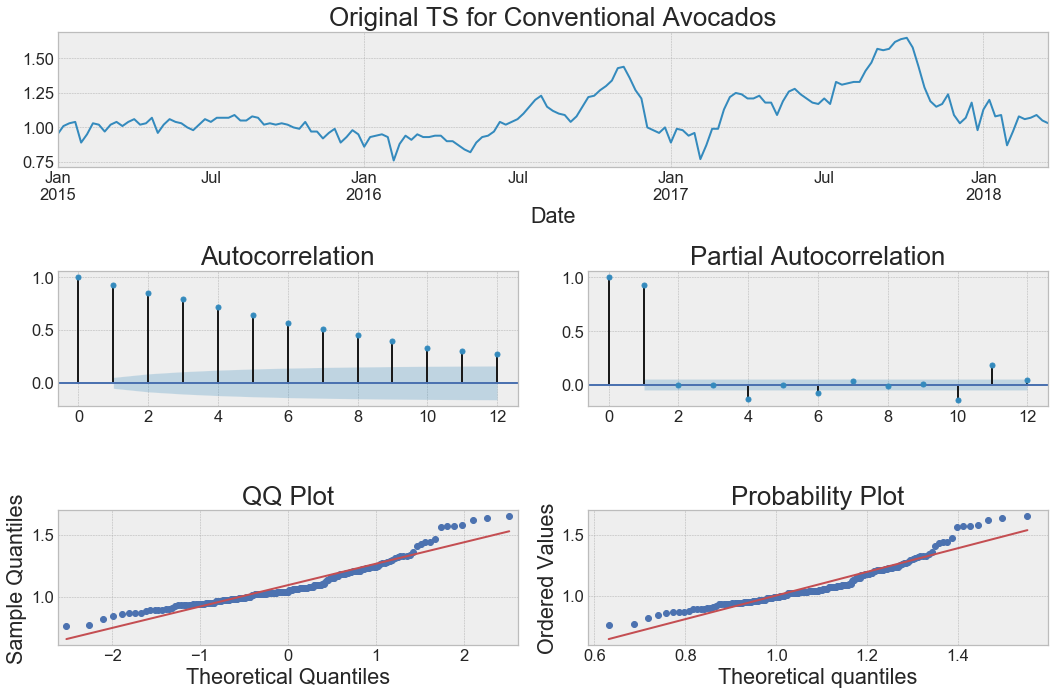

In [83]:
tsplot (df_con['Average_Price_Conventional'], lags = 12)

In [29]:
def my_acf_pacf (df, lag):
    fig, ax = plt.subplots(3, figsize=(15,12))
    ax[0] = plot_acf(df, ax=ax[0], lags=lag)
    ax[1] = plot_pacf(df, ax=ax[1], lags=lag)
    
    ## Graphical test for best AR-order
    BIC_1 = np.zeros(lag)
    for p in range(lag):
        mod_1 = ARMA(df, order=(p,0))
        res_1 = mod_1.fit()
        # Save BIC for AR(p)    
        BIC_1[p] = res_1.bic
    
    # Plot the BIC as a function of p
    ax[2] = plt.plot(range(1,lag), BIC_1[1:lag], marker='o')
    plt.xlabel('Order of AR Model')
    plt.ylabel('BIC')
    plt.title('Graphical AR-order simulation')
    fig.tight_layout()
    plt.show()
    

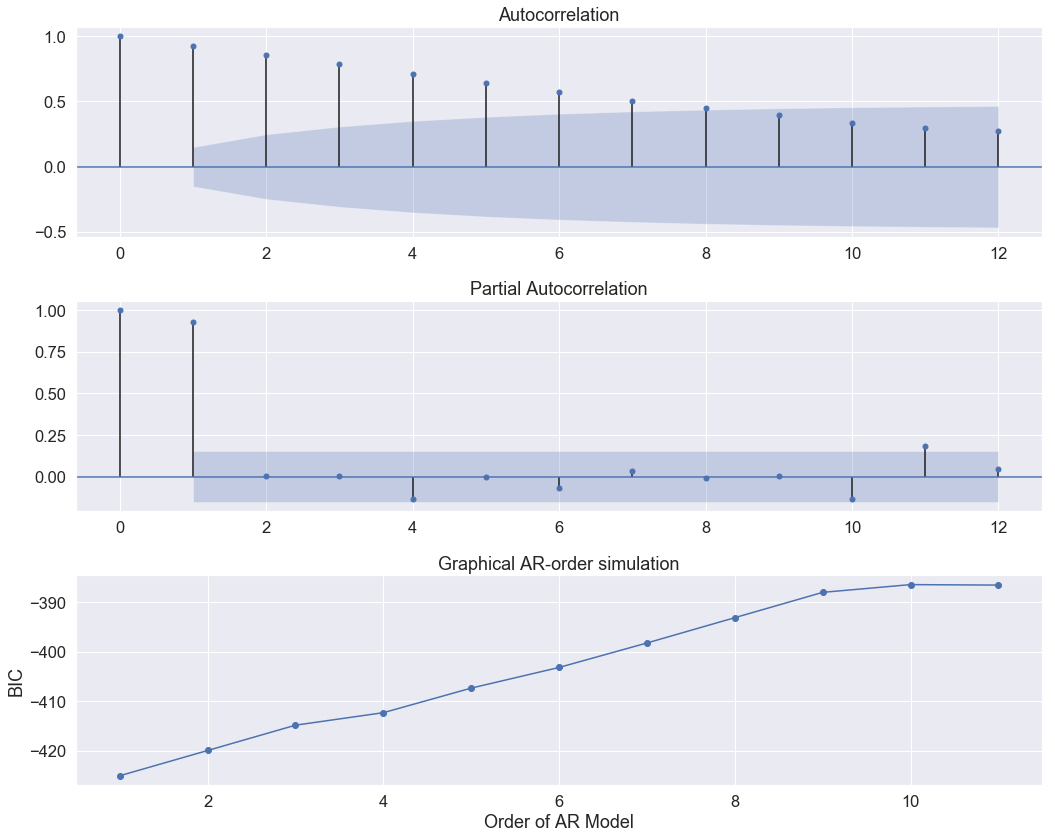

In [55]:
my_acf_pacf(df = df_con['Average_Price_Conventional'], lag = 12)

### 3.2  Transformation, Smoothing, and Differencing

In [31]:
## Influenced by: https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

# Transformation - log ts
df_copy = df_con.copy()
df_copy['ts_log'] = df_copy['Average_Price_Conventional'].apply(lambda x: np.log(x))

# Transformation - 7-day moving average ts ---> non-stationary
#df_copy['7_day_mov'] = df_copy['Average_Price_Conventional'].rolling(window = 7, center = False).mean()
#df_copy = df_copy.dropna()

## Differencing: Differencing is performed by subtracting the previous observation from the current observation.
# Transformation - Difference between logged ts and first-order difference logged ts
df_copy['ts_log_diff'] = df_copy['ts_log'] - df_copy['ts_log'].shift(1)
df_copy = df_copy.dropna()

# Perform stationarity test
## select univariate TS
df_log_diff = df_copy[['ts_log_diff']]

test_stationarity(df = df_log_diff, ts = 'ts_log_diff', layout = 'Rolling Mean and Standard Deviation for Log-Diff Time-Series')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value



Results - Dickey fuller test
Test Statistic                  -4.574868
p-value                          0.000144
# Lags Used                      9.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64

----------------------------------
Results - KPSS Test
Test Statistic: 0.06831
p-value: 0.1


In [32]:
#decompose
decompose = seasonal_decompose(df_log_diff)

#trend
trend   = decompose.trend
#seasonality
seasonal = decompose.seasonal
#residuals
residual   = decompose.resid

## Plot Decomposition
plot_decomposition (df = df_log_diff, ts = 'ts_log_diff', trend = trend, seasonal=seasonal, residual=residual, title = 'Decomposition of Log-Diff Time-Series')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



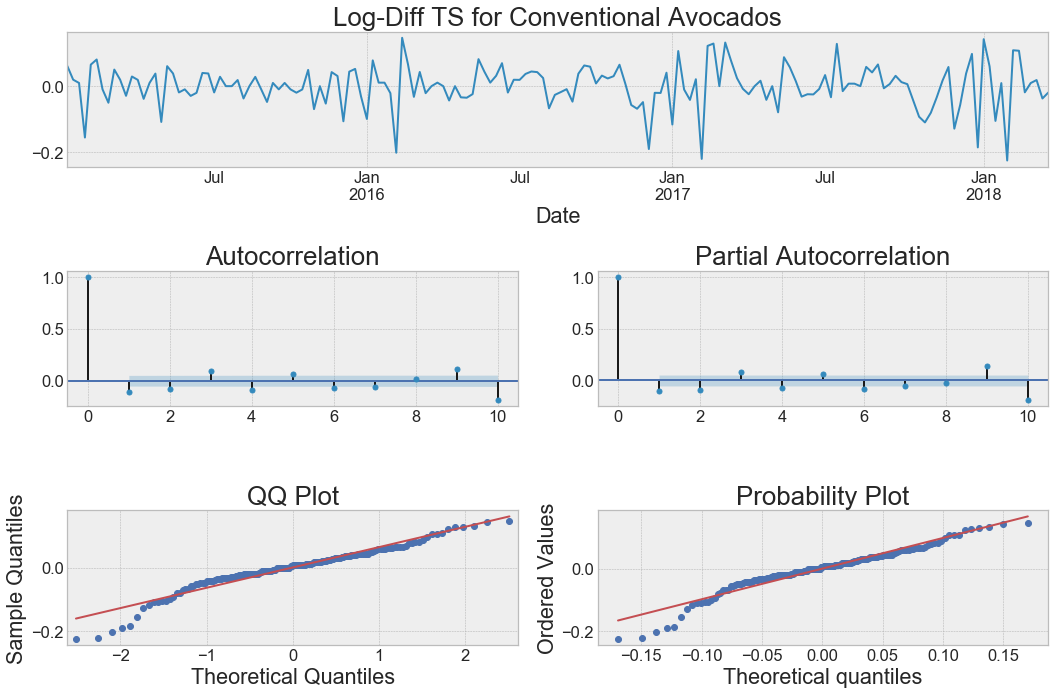

In [87]:
tsplot (df_log_diff['ts_log_diff'], lags = 10)

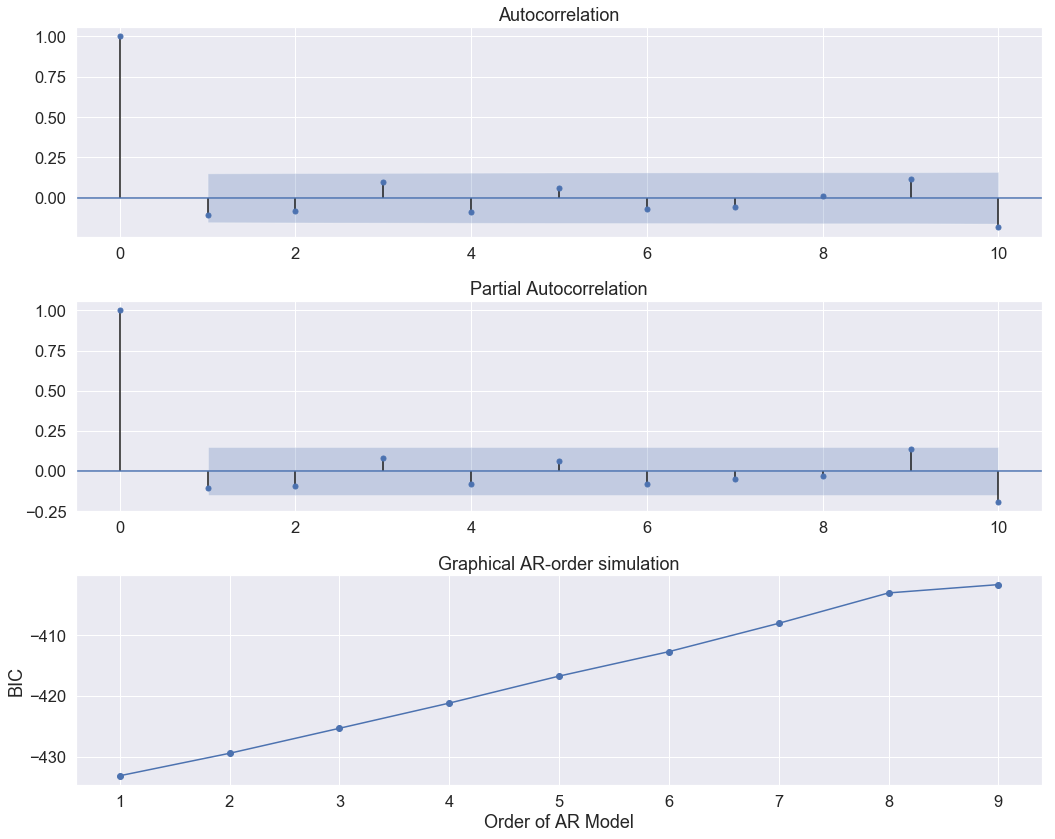

In [56]:
my_acf_pacf(df = df_log_diff['ts_log_diff'], lag = 10 )

## 4. Fitting appropriate model

### 4.1 Classical Approach

#### Autoregressive Moving Average (ARMA)

In [57]:
### Best Model: ARMA ###
### ARMA (4,3) ###
### Source: http://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.arma_order_select_ic.html

model_fit = sm.tsa.arma_order_select_ic(df_con, max_ar=5, max_ma=5, ic='aic', trend='c')
print('ARMA(p,q) =', model_fit['aic_min_order'], 'is the best.')

ARMA(p,q) = (4, 3) is the best.


In [89]:
# instantiate the ARMA model
model_ARMA = ARIMA(df_con['Average_Price_Conventional'], order = (4, 0, 3))
 
# fit the model
results_ARMA = model_ARMA.fit()
 
# collect the predicted results
predictions_ARMA = round(results_ARMA.predict(), 2)
 
# put the predictions into a DataFrame with Date and Predicted Price as columns
preds_ARMA = pd.DataFrame(list(zip(list(predictions_ARMA.index),list(predictions_ARMA))),columns=['Date','PredictedPrice']).set_index('Date')
 
# combine the original data set with the predicted data
predicted_df_ARMA = pd.merge(df_con[1:], preds_ARMA, left_index=True, right_index=True)

In [59]:
def my_comparison (df, prediction):
    
    ## Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(df, prediction))
    rmse = round(rmse, 3)
    print ('RMSE:', rmse)
    print ('------------')
    
    ## Mean Absolute Percentage Error
    abs_error = np.abs(df-prediction)
    actual = df.copy()
    mape = np.round(np.mean(abs_error/actual),3)
    print ('MAPE:', mape)
    print ('------------')
    
    ## MAE
    y_true = df
    y_pred = prediction
    mae = round(mean_absolute_error(y_true, y_pred),3)
    print ('MAE:', mae)

In [60]:
my_comparison(df = df_con['Average_Price_Conventional'], prediction = predictions_ARMA)

RMSE: 0.063
------------
MAPE: 0.045
------------
MAE: 0.048


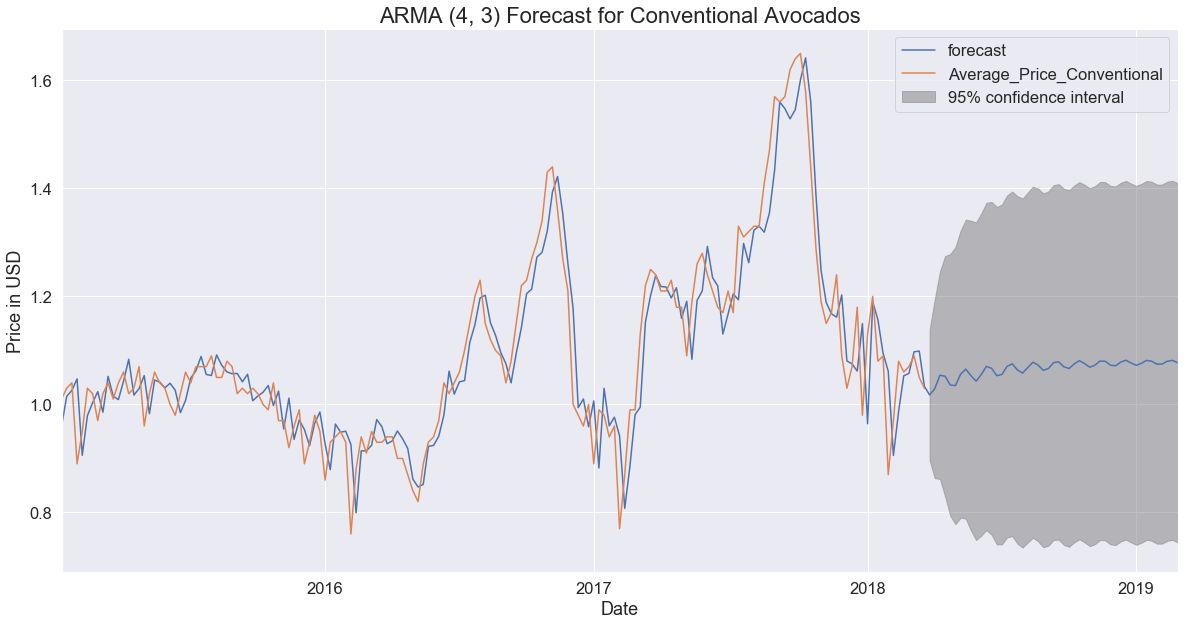

In [61]:
results_ARMA.plot_predict(start='2015-01-11', end = '2019-03')
rcParams['figure.figsize'] = 20, 10
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('ARMA (4, 3) Forecast for Conventional Avocados', fontsize=22)
plt.show()

#### Autoregresive Integrated Moving Average (ARIMA)

In [62]:
### Best Model for ARIMA ###
### (0,1,0)
### Source: https://github.com/tgsmith61591/pmdarima/blob/master/examples/quick_start_example.ipynb

stepwise_fit = auto_arima(df_con, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=False, d=1, D=0, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True,  
                          stepwise=True)  

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-428.895, BIC=-422.647, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-427.018, BIC=-417.646, Fit time=0.066 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-427.026, BIC=-417.654, Fit time=0.056 seconds
Total fit time: 0.180 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  168
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 216.448
Method:                           css   S.D. of innovations              0.067
Date:                Thu, 27 Jun 2019   AIC                           -428.895
Time:                        15:26:21   BIC                           -422.647
Sample:                             1   HQIC                          -426.360
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.005      0.093      0.926      -0.010       0.011
==============================================================================
"""

In [63]:
# instantiate the ARIMA model
model = ARIMA(df_con['Average_Price_Conventional'], order = (0, 1, 0))
 
# fit the model
results_ARIMA = model.fit()
 
# collect the predicted results
predictions_ARIMA = round(results_ARIMA.predict(), 2)
 
# put the predictions into a DataFrame with Date and Predicted Price columns
preds_ARIMA = pd.DataFrame(list(zip(list(predictions_ARIMA.index),list(predictions_ARIMA))),columns=['Date','PredictedPrice']).set_index('Date')
 
# combine the original data set with the predicted data
predicted_df_ARIMA = pd.merge(df_con[1:], preds_ARIMA, left_index=True, right_index=True)

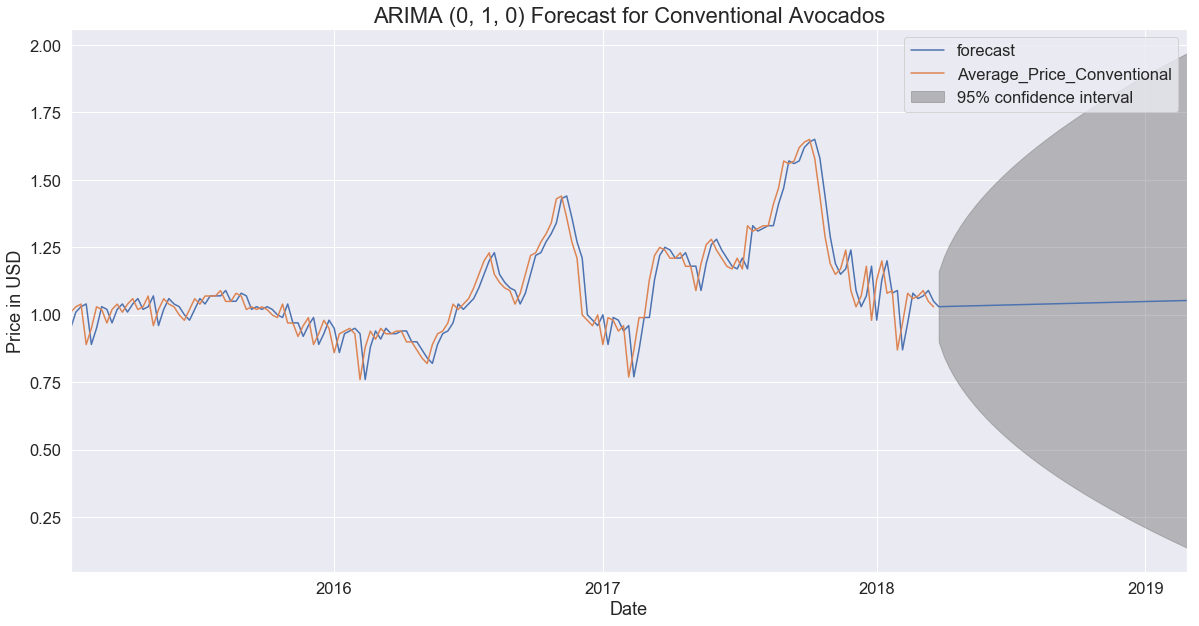

In [64]:
results_ARIMA.plot_predict(start='2015-01-11', end = '2019-03')
rcParams['figure.figsize'] = 20, 10
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('ARIMA (0, 1, 0) Forecast for Conventional Avocados', fontsize=22)
plt.show()

#### Seasonal Autoregressive Integrated Moving Average (SARIMA)

In [65]:
### Best Model for SARIMA ###
## SARIMAX(1, 1, 0)x(1, 1, 0, 52)
### Further reading: Forecasting seasonal data in Pyhton
## Source: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

sarimax_model = auto_arima(df_con['Average_Price_Conventional'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(sarimax_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-283.088, BIC=-277.581, Fit time=0.827 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-288.459, BIC=-277.445, Fit time=12.304 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=-288.034, BIC=-279.773, Fit time=2.968 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 52); AIC=-286.699, BIC=-272.931, Fit time=81.285 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-287.880, BIC=-279.619, Fit time=8.023 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=-287.638, BIC

In [43]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  169
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                 148.230
Date:                            Thu, 27 Jun 2019   AIC                           -288.459
Time:                                    15:15:54   BIC                           -277.445
Sample:                                         0   HQIC                          -283.988
                                            - 169                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.007     -0.075      0.940      -0.014       0.013
ar.L1          0.1672      0.075      2.223      0.026       0.020       0.315
ar.S.L52      -0.2263      0.111     -2.033      0.042      -0.445      -0.008
sigma2         0.0044      0.001      7.841      0.000       0.003       0.006
===================================================================================
Ljung-Box (Q):                       40.07   Jarque-Bera (JB):                 8.13
Prob(Q):                              0.47   Prob(JB):                         0.02
Heteroskedasticity (H):               1.52   Skew:                            -0.47
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# instantiate the ARIMA model
model = sm.tsa.statespace.SARIMAX(df_con['Average_Price_Conventional'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False)
 
# fit the model
results_sarima = model.fit()
 
# collect the predicted results
predictions_sarima = round(results_sarima.predict(), 2)
 
# put the predictions into a DataFrame with Date and Predicted Price columns
preds_sarima = pd.DataFrame(list(zip(list(predictions_sarima.index),list(predictions_sarima))),columns=['Date','Predicted Price']).set_index('Date')
 
# combine the original data set with the predicted data
predicted_df_sarima = pd.merge(df_con[1:], preds_sarima, left_index=True, right_index=True)

# make forecast
start = len(predicted_df_sarima)  
end = len(predicted_df_sarima) + 60

# typ= 'levels' to return the differenced values to the original units
forecasted_values = results_sarima.predict(start=start,end=end,typ='levels')
forecasted_values = pd.DataFrame(forecasted_values)
forecasted_values.columns = ['Forecasted Price']

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



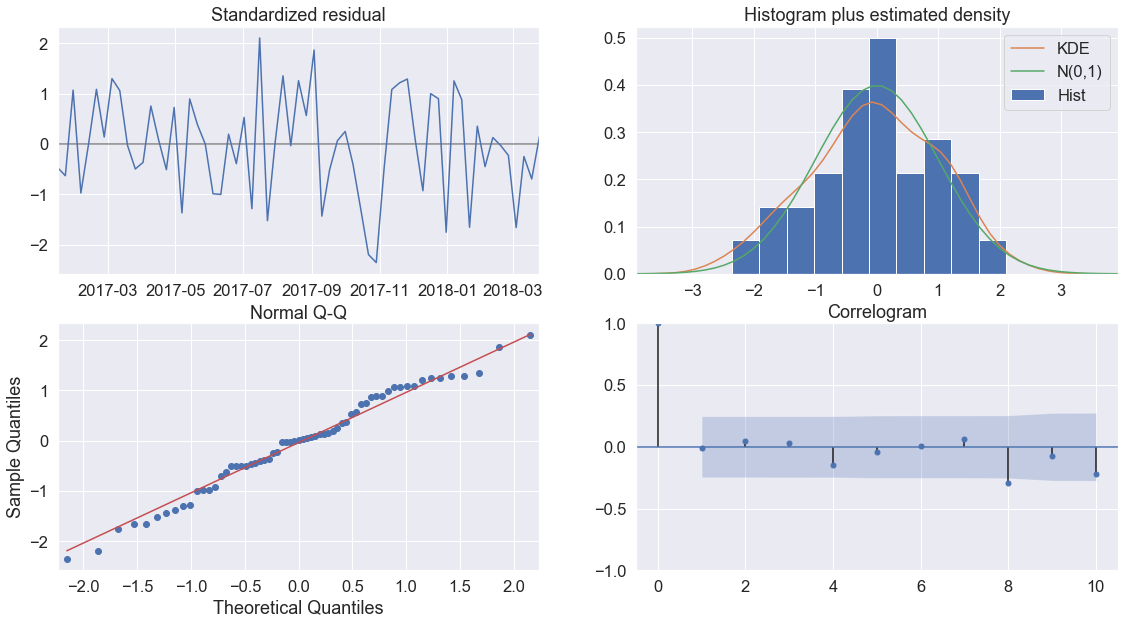

In [99]:
results_sarima.plot_diagnostics(figsize=(19, 10))
plt.show()

In [45]:
my_comparison(df = df_con['Average_Price_Conventional'], prediction = predictions_sarima)

RMSE: 0.109
------------
MAPE: 0.055
------------
MAE: 0.057


In [46]:
trace_1 = go.Scatter(
                x=predicted_df_sarima.index,
                y=predicted_df_sarima['Average_Price_Conventional'],
                name = "Avg. Price",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_2 = go.Scatter(
                x=predicted_df_sarima.index,
                y=predicted_df_sarima['Predicted Price'],
                name = 'Pred. Price',
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

trace_3 = go.Scatter(
                x=forecasted_values.index,
                y=forecasted_values['Forecasted Price'],
                name = 'Forecasted Price',
                opacity = 0.8)


data = [trace_1, trace_2, trace_3]

layout = dict(
    title = 'Average, Predicted and Forecasted Price of Conventional Avocados with SARIMAX (1, 1, 0)x(1, 1, 0, 52)',
    yaxis=dict(title="Average Price in USD"),
    xaxis = dict(
        range = ['2015-01-01','2020-02-31'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

<p>

### 4.2 Forecast with FBProphet

Tutorials on how to use Prophet in Python:<p>
[1] https://mode.com/example-gallery/forecasting_prophet_python_cookbook/
<br>
[2] https://facebook.github.io/prophet/docs/quick_start.html
<p>
For the code, see the file: Forecast_with_FBProphet.ipynb

## 5. Comparison

In [47]:
forecast_1 = forecasted_values[(forecasted_values.index >= '2018-03-25' ) & (forecasted_values.index <= '2019-03-03')]

In [48]:
forecast_2 = pd.read_csv('forecast_prophet.csv', index_col = 'ds', parse_dates = True)

In [49]:
forecast_2 = forecast_2[['yhat']]
forecast_2 = forecast_2[(forecast_2.index >= '2018-03-25' ) & (forecast_2.index <= '2019-03-03')]
forecast_2 = forecast_2['yhat'].resample('W').mean()
forecast_2 = pd.DataFrame(forecast_2)

In [50]:
trace_1 = go.Scatter(
                x=forecast_1.index,
                y=forecast_1['Forecasted Price'],
                name = "SARIMAX",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_2 = go.Scatter(
                x=forecast_2.index,
                y=forecast_2['yhat'],
                name = 'FBProphet',
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [trace_1, trace_2]

layout = dict(
    title = 'Comparison betw. SARIMAX and FBProphet Forecast',
    yaxis=dict(title="Average Price in USD"),
    xaxis = dict(
        range = ['2018-03-01','2019-03-31'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig)